In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt

from mrlattice.lattice.generate import *
from mrlattice.lattice.validate import *

In [2]:
# this notebook requires mrlattice version:
VERSION = "0.1.5"

In [3]:
%run prepare_notebook.ipynb

The following names are now available:

<class '__main__.LatticeArrayPlotWidget'>
<class '__main__.SuperimposeLatticeArrayPlotWidget'>


In [4]:
%run 0.1.5-01_configuration_loops.ipynb
clear_output()

In [5]:
print(NewValidateLattice)

<class '__main__.NewValidateLattice'>


In [6]:
# interactive plots in notebook
# %matplotlib notebook
# open external window with plot
# %matplotlib qt
# for saving widget state
%matplotlib inline

if "inline" in matplotlib.get_backend():
    plt.rcParams["figure.figsize"] = (14, 14)
else:
    plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Summary

We derive the validation tests for lattice array properties and demonstrate how to use them.


# Validation of Parameter Values

We start with the simple task of validating if the configured properties of the lattice actually translate to the lattice array. Until now we have never checked, if this is the case, other than manually looking at plotted lattices during development. We will now derive concrete tests for the following properties:
- buffer size
- finest width
- number of borders
- width of border regions (for both schemes)

We don't need to check the `repeat` property as it is already covered by general unit tests.

As these are the basic properties of the diagonal borders lattice (or any derived lattice), it is fitting to test them on `LatticeArray` instances. Any derived classes rely on a properly tested superclass. Additionally some derived lattices may change or obscure the meaning of these properties and make them harder to test.

A validation test in the domain of `ValidateLattice` has to be a function with one positional argument for the `LatticeArray` instance to test. If the test fails, it must raise a `ValidationError`.


## Buffer Spatial Size and Finest Width

The buffer is referred to as the region with coarsest resolution. The finest width referrs to the spatial width of the region with the finest resolution.

These two parameters are the simplest to validate. They can be directly compared to their respective values from the `LatticeArray` instance. We also test if there even exists a region with the required resolution. This appears natural when searching for the buffer or finest region in each the time slice.

In [7]:
def test_buffer_size(lattice):
    """Test the spatial width of the buffer(=coarsest) region."""
    
    buffer_res = 2**lattice.coarse_steps.value
    
    for t,ts in enumerate(lattice.array):
        
        # filter time slice for correct coarsest region
        buffer = list(filter(lambda reg: reg[1] == buffer_res, ts))
        if not buffer:
            raise ValidationError(
                f"No region with resolution of buffer ({buffer_res}) "
                f"found in slice {t}:\n{ts}",
                "test_buffer_size")
        
        # test buffer spatial width
        for buffer_region in buffer:
            if buffer_region[-1] < lattice.buffer.value:
                raise ValidationError(
                    f"Spatial width of buffer for slice {t} is incorrect:\n"
                    f"{buffer_region} is not >= {lattice.buffer.value}",
                    "test_buffer_size")

In [8]:
def test_finest_width(lattice):
    """Test the spatial width of the finest region."""
    
    for t,ts in enumerate(lattice.array):
        
        # filter time slice for correct finest region
        finest = list(filter(lambda reg: reg[1] == 1, ts))
        if not finest:
            raise ValidationError(
                f"No region with resolution of finest ({1}) "
                f"found in slice {t}:\n{ts}",
                "test_finest_width")
        
        # test finest region's spatial width
        for finest_region in finest:
            if finest_region[-1] < lattice.finest_width.value:
                raise ValidationError(
                    f"Spatial width of finest region for slice {t} is incorrect:\n"
                    f"{finest_region} is not >= {lattice.finest_width.value}",
                    "test_finest_width")

## Number of Borders

The number of borders is set by the `coarse_steps` property and is reflected in the number of different regions in any time slice. Testing the number of regions relies on the fact, that no neighboring regions have the same resolution. This will be tested later.

In [9]:
def test_coarse_steps(lattice):
    """Test number of coarse borders."""
    
    for t,ts in enumerate(lattice.array):
            
        # compare with coarse_steps property
        if (reg_num := len(ts)-1) != lattice.coarse_steps.value:
            raise ValidationError(
                f"The number of region borders for slice {t} is incorrect:\n"
                f"{reg_num} is not {lattice.coarse_steps.value}",
                "test_coarse_steps"
            )

## Spatial Width of Coarsening Regions

The spatial width of the coarsening regions is controlled with the `borders_width` property. Here it is important to distinguish between the two schemes, namely the "fixed number" (Ipp) and "fixed width" (Kayran) schemes. The former is easy to test, as the value of the property directly gives the number of cells in the coarsening regions. The "fixed width" scheme requires to calculate the number of cells for a given resolution in advance. However, this approach would copy the way this scheme is implemented and gives rise to the risk of repeating the same errors in the tests. Therefore it is better to calculate the width of each region as it is present in the given lattice and compare with the set value of `borders_width`.

With both schemes there is a catch, though. Due to the stairs-like shape of the diagonal borders, the actual width of any given region will be either `borders_width` or `borders_width`+1. This is most easily understood when looking at the "fixed number" scheme. Here, if the current time slice has $n$ number of cells, which shall match the value of `borders_width`, the next time slice must have $n+1$ cells of that same resolution. This is a necessity for keeping the edges straight. For the "fixed width" scheme the same applies, except that now the difference won't be exactly the width of 1 cell. By demanding, that the value of `borders_width` is perfectly filled if possible, the restrictions become asymmetric. The difference of `borders_width` and the actual value in the lattice has to be smaller than the resolution of one cell in general. From the asymmetric condition it follows, that if the actual region is narrower, the difference can't be equal or larger than one cell. However, if the actual region is wider, the difference can't be larger than one cell. It can be the same, which is the case when the `borders_width` can be perfectly filled by cells of the given resolution.

All of these considerations give rise to the following validation test.

In [10]:
def test_borders_width(lattice):
    """Test coarsening regions' spatial width"""
    
    for t,ts in enumerate(lattice.array):
        # counting from the left (small spatial coordinate)
        # skipping buffer and finest regions
        for ri, r in enumerate(ts[1:-1], 1):
            if lattice.scheme.name == lattice.scheme.FIXED_WIDTH_SCHEME:
                # asymmetric intervall
                if -r[1] >= (r[-1]*r[1] - lattice.borders_width.value) > r[1]:
                    raise ValidationError(
                        f"The width of the coarsening region number {ri} "
                        f"does not match requested width of {lattice.borders_width.value} "
                        f"at time slice {t}.",
                        "test_borders_width")    
            elif lattice.scheme.name == lattice.scheme.FIXED_NUMBER_SCHEME:
                if r[-1] - lattice.borders_width.value not in [0, 1]:
                    raise ValidationError(
                        f"The number of cells for coarsening region number {ri} "
                        f"does not match requested number of {lattice.borders_width.value} "
                        f"at time slice {t}.",
                        "test_borders_width")
            else:
                raise ValidationError(
                    f"No test available for lattice scheme: {lattice.scheme.name}",
                    "test_borders_width")

## Testing on Concrete Examples


### Fixed Width Scheme Test Lattice

In [11]:
FIXED_WIDTH_PROPS = {
    "scheme":"fixed_width",
    "coarse_steps":4,
    "borders_width":30,
    "buffer":3,
    "finest_width":7,
    "repeat":4,
}
fw_lattice = LatticeArray(**FIXED_WIDTH_PROPS)
fw_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
fw_valid = NewValidateLattice(fw_lattice, sorted_props=prop_sort)

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

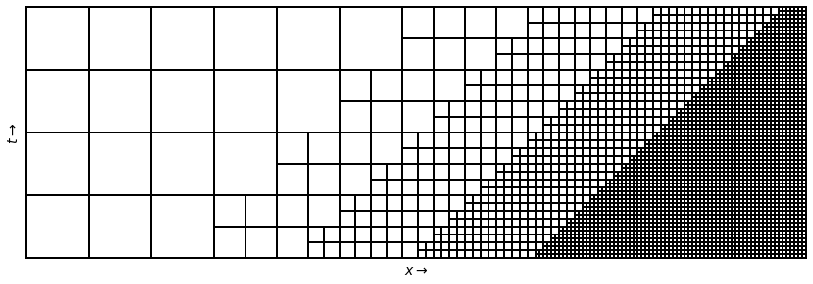

In [12]:
ww = LatticeArrayPlotWidget(lattice=fw_lattice)
ww.alpha_bg.value = True
ww._plot_button_on_click()
display(ww)

### Fixed Number Scheme Test Lattice

In [13]:
FIXED_NUMBER_PROPS = {
    "scheme":"fixed_number",
    "coarse_steps":4,
    "borders_width":8,
    "buffer":3,
    "finest_width":7,
    "repeat":4,
}
fn_lattice = LatticeArray(**FIXED_NUMBER_PROPS)
fn_lattice.generate_array()
prop_sort = [
    "buffer",
    "coarse_steps",
    "borders_width",
    "finest_width",
    "repeat",
]
fn_valid = NewValidateLattice(fn_lattice, sorted_props=prop_sort)

LatticeArrayPlotWidget(children=(VBox(children=(HBox(children=(VBox(children=(Label(value='Number of Borders b…

Output()

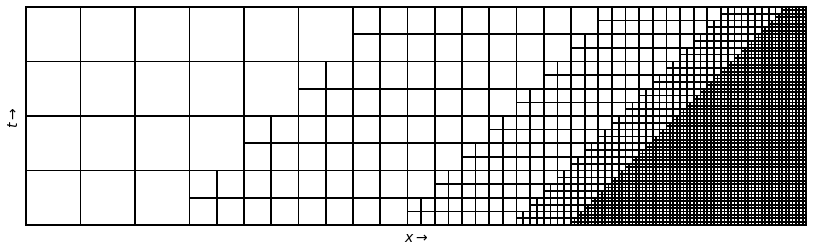

In [14]:
wn = LatticeArrayPlotWidget(lattice=fn_lattice)
wn.alpha_bg.value = True
wn._plot_button_on_click()
display(wn)

## Example Validation Test Execution

In [15]:
# fixed width scheme
fw_valid.add_test("buffer width", test_buffer_size)
fw_valid.add_test("finest width", test_finest_width)
fw_valid.add_test("coarse steps", test_coarse_steps)
fw_valid.add_test("borders width", test_borders_width)
fw_valid(stdout=sys.stdout)

borders_width
Test coarsening regions' spatial width ... 
	PASSED.
buffer_width
Test the spatial width of the buffer(=coarsest) region. ... 
	PASSED.
coarse_steps
Test number of coarse borders. ... 
	PASSED.
finest_width
Test the spatial width of the finest region. ... 
	PASSED.


----------------------------------------------------------------------
Ran 4 tests:
	4 passed

PASSED!


True

In [16]:
# fixed number scheme
fn_valid.add_test("buffer width", test_buffer_size)
fn_valid.add_test("finest width", test_finest_width)
fn_valid.add_test("coarse steps", test_coarse_steps)
fn_valid.add_test("borders width", test_borders_width)
fn_valid(stdout=sys.stdout)

borders_width
Test coarsening regions' spatial width ... 
	PASSED.
buffer_width
Test the spatial width of the buffer(=coarsest) region. ... 
	PASSED.
coarse_steps
Test number of coarse borders. ... 
	PASSED.
finest_width
Test the spatial width of the finest region. ... 
	PASSED.


----------------------------------------------------------------------
Ran 4 tests:
	4 passed

PASSED!


True